# Figure 7

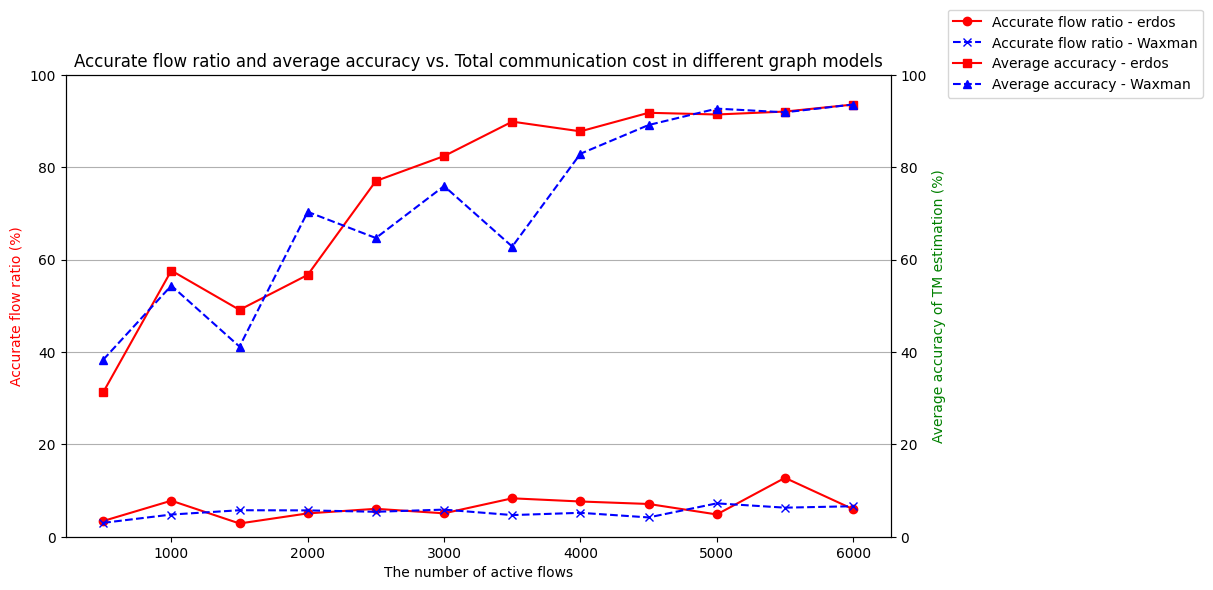

In [6]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import time

def calculate_accurate_flow_ratio_and_average_accuracy(flow_stats_file, trafgen_stats_file):
    # Load the JSON data
    with open(flow_stats_file, 'r') as f:
        flow_stats = json.load(f)
        
    with open(trafgen_stats_file, 'r') as f:
        trafgen_stats = json.load(f)
    
    # Initialize counters
    accurate_flow_count = 0
    total_flows = 0
    accuracy_sum = 0

    # Calculate accurate flow ratio and average accuracy
    for flow_id, flow_stat in flow_stats.items():
        if flow_id == "1000000000":
            continue
        
        total_flows += 1
        if flow_id in trafgen_stats:
            trafgen_stat = trafgen_stats[flow_id]
            if trafgen_stat == 0:
                continue
            if flow_stat == trafgen_stat:
                accurate_flow_count += 1
            
            error_rate = abs(flow_stat - trafgen_stat) / trafgen_stat
            accuracy = 1 - error_rate
            accuracy_sum += accuracy
    
    accurate_flow_ratio = accurate_flow_count / total_flows if total_flows > 0 else 0
    average_accuracy = accuracy_sum / total_flows if total_flows > 0 else 0

    return accurate_flow_ratio, average_accuracy

# Prepare data paths
num_flows = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]
flow_stats_files = [f'stats/flow_stats_{num_flow}.json' for num_flow in num_flows]
trafgen_stats_files = [f'stats/trafgen_stats_{num_flow}.json' for num_flow in num_flows]

flow_stats_waxman_files = [f'stats/flow_stats_waxman_{num_flow}.json' for num_flow in num_flows]
trafgen_stats_waxman_files = [f'stats/trafgen_stats_waxman_{num_flow}.json' for num_flow in num_flows]

results = []

# Collect metrics
for num_flow, flow_file, trafgen_file in zip(num_flows, flow_stats_files, trafgen_stats_files):
    accurate_flow_ratio, average_accuracy = calculate_accurate_flow_ratio_and_average_accuracy(flow_file, trafgen_file)
    results.append([num_flow, accurate_flow_ratio, average_accuracy, 'erdos'])

for num_flow, flow_file, trafgen_file in zip(num_flows, flow_stats_waxman_files, trafgen_stats_waxman_files):
    accurate_flow_ratio, average_accuracy = calculate_accurate_flow_ratio_and_average_accuracy(flow_file, trafgen_file)
    results.append([num_flow, accurate_flow_ratio, average_accuracy, 'Waxman'])

# Dataframe and CSV
results_df = pd.DataFrame(results, columns=['The number of active flows', 'Accurate Flow Ratio', 'Average Accuracy', 'Model'])
timestamp = time.strftime("%Y%m%d-%H%M%S")
filename = f"data/accuracy_results_{timestamp}.csv"
results_df.to_csv(filename, index=False)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
colors = {'erdos': 'r', 'Waxman': 'b'}
markers = {'erdos': 'o', 'Waxman': 'x', 'erdos-acc': 's', 'Waxman-acc': '^'}  # Square and triangle markers
line_styles = {'erdos': '-', 'Waxman': '--'}

for model in results_df['Model'].unique():
    subset = results_df[results_df['Model'] == model]
    ax1.plot(subset['The number of active flows'], subset['Accurate Flow Ratio'] * 100, color=colors[model], marker=markers[model], linestyle=line_styles[model], label=f'Accurate flow ratio - {model}')
    ax2.plot(subset['The number of active flows'], subset['Average Accuracy'] * 100, color=colors[model], marker=markers[model+'-acc'], linestyle=line_styles[model], label=f'Average accuracy - {model}')

ax1.set_xlabel('The number of active flows')
ax1.set_ylabel('Accurate flow ratio (%)', color='r')
ax2.set_ylabel('Average accuracy of TM estimation (%)', color='g')

plt.title('Accurate flow ratio and average accuracy vs. Total communication cost in different graph models')
ax1.set_ylim(0, 100)
ax2.set_ylim(0, 100)

# Position legend outside of the plot area
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.95)  # Adjust the right margin to make space for the legend

plt.grid(True)
plt.show()

